<a href="https://colab.research.google.com/github/Carmen-Cai/FYP/blob/main/GAA_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Settgings

##Google docs

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
# !ls "/content/drive/My Drive/FYP/ECGpdf2data/data/train/cropped_png/Recur"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##imports

In [ ]:
# !pip install -U scikit-learn
# !pip install visdom
!pip install pytorchtools
# from pytorchtools import EarlyStopping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch 
import torch.nn as nn
import torchvision
from torchvision.utils import save_image
import torchvision.transforms as T 
from torch import optim
import torch.nn.functional as F
import numpy as np 
import os
from os import path
#from google.colab import auth
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.pyplot as plt
from PIL import Image
from statistics import mean
import torch.utils.data as data
# import EarlyStopping
# from pytorchtools import EarlyStopping
#auth.authenticate_user()

#from visdom import Visdom 

torch.cuda.is_available()

True

##Parameter settings

In [ ]:
args = {
    #"root":"/media/imed/GAA",
    "root_GAA":"/content/drive/My Drive/FYP_Yixin_Cai/GAA_data",#/origin_png/",
    "root_CNN":"/content/drive/My Drive/FYP_Yixin_Cai/CNN_data",
    "img_save_path":"./save_img",
    "epoches":20,#400,
    "lr": 0.8e-4,#5, 来回 -》4
    "lr_cnn":1e-3,
    "lr_ed": 1e-3,
    "snapshot":100,
    "test_step":1,
    "ckpt_path":"/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/checkpoint/",
    "ckpt_path2":"/content/drive/My Drive/FYP_Yixin_Cai/CNN_data/checkpoint/",
    #"ckpt_path":"/media/imed/Checkpoint/GAA/",
    "batch_size":25,
    "cnn_batch_size":5,
    "name":"GAA",
    "drop_out":0.2,
    "best_acc":0.9,
    "loss_img_folder":3,
    "time":0
}

#Data Loading

##Basic Functions

In [ ]:
def random_HSV(image,h_limit=(-180,180),s_limit=(-255,255),v_limit=(-255,255),u=0.5):
    if np.random.random() < u:
        #rgb -> hsv
        image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(image)
        h_shift = np.random.randint(h_limit[0],h_limit[1] + 1 )
        h_shift = np.uint8(h_shift)
        h += h_shift 
        s_shift = np.random.uniform(s_limit[0],s_limit[1])
        s = cv2.add(s,s_shift)
        v_shift = np.random.uniform(v_limit[0],v_limit[1])
        v = cv2.add(v,v_shift)
        image = cv2.merge((h,s,v))
        image = cv2.cvtColor(image,cv2.COLOR_HSV2BGR)
        # print("HSV image type", type(image),image.shape)
    return image

def random_ShiftScaleRotate(image,mask,shift_limit=(-0.0,0.0),
                            scale_limit=(-0.0,0.0),rotate_limit=(-0.0,0.0),
                            aspect_limit=(-0.0,0.0),borderMode=cv2.BORDER_CONSTANT,u=0.5):

    if np.random.random() < u:
        height,width,channel = image.shape               
        angle = np.random.uniform(rotate_limit[0],rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0],1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0],1 + aspect_limit[1])

        sx = scale * aspect / (aspect ** 0.5)
        sy = scale * (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0],shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0],shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc,-ss],[ss,cc]])

        box0 = np.array([[0,0],[width,0],[width,height],[0,height]])
        box1 = box0 - np.array([width / 2,height / 2])
        box1 = np.dot(box1,rotate_matrix.T) + np.array([width / 2 + dx,height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0,box1)
        image = cv2.warpPerspective(image,mat,(width,height),flags=cv2.INTER_LINEAR,borderMode=borderMode,borderValue=(0,0,0))
        mask = cv2.warpPerspective(mask,mat,(width,height),flags=cv2.INTER_LINEAR,borderMode=borderMode,borderValue=(0,0,0))

    return image,mask


def randomFlip_H(image,mask,u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        if type(mask)==type(np.array([1])):
            mask = cv2.flip(mask,1)
    return image,mask

def randomFlip_V(image,mask,u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    return image,mask

def randomRotate_90(image,mask,u=0.5):
    if np.random.random() < u:
        image = np.rot90(image)
        mask = np.rot90(mask)

    return image,mask

def get_one_hot(label,N):
    size = list(label.size())
    label = label.view(-1)
    ones = torch.sparse.torch.eye(N)
    ones = ones.index_select(0,label)
    size.append(N)

    return ones.view(*size)  

def param_copy(param_s,param_t,alpha,epoch):
    # param_s = list(param_s)
    # param_t = list(param_t)
    if epoch <= 1:
        for ps,pt in zip(param_s,param_t):
            pt.data[:] = ps.data[:]

    else:
        for ps,pt in zip(param_s,param_t):
            pt.data.mul_(alpha)
            pt.data.add_(ps.data * (1-alpha))

In [ ]:
from torch.nn.modules import loss

def plot_loss(loss_dataset,loss_name,loss_dataset2=[],loss_name2=''):# visualize the loss as the network trained
  
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(loss_dataset)+1),loss_dataset, label=loss_name)
  plt.ylim(0, 1.1*max(loss_dataset))
  if loss_dataset2!=[]:
    plt.plot(range(1,len(loss_dataset2)+1),loss_dataset2,label=loss_name2)
    plt.ylim(0, 1.1*max(loss_dataset) if max(loss_dataset)> max(loss_dataset2) else 1.1*max(loss_dataset2))


  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.xlim(0, len(loss_dataset)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  img_name=loss_name+loss_name2 if loss_name2 != '' else loss_name
  # fig.savefig('/content/drive/My Drive/FYP_Yixin_Cai/CNN_data/loss/loss_img/'+str(args['time'])+"_"+img_name+'.png', bbox_inches='tight' )

##Class Image and Choroid_loader

In [ ]:
class ImageFloder(data.Dataset):
    def __init__(self,root_path,datasets="GAA",mode="train"):
        self.root = root_path
        self.mode = mode
        self.dataset = datasets

        if self.dataset == "GAA":#"CHOROID":
            if self.mode=="train":
                # self.images, self.labels, self.img_target, self.mask_target = read_datasets(self.root,self.mode) #mask_target is the label for cnn model
                self.images, self.labels, self.img_target = read_datasets(self.root,self.mode,self.dataset)
            
            if self.mode=="validation":
                # self.images, self.labels, self.img_target, self.mask_target = read_datasets(self.root,self.mode) #mask_target is the label for cnn model
                self.images, self.labels, self.img_target = read_datasets(self.root,self.mode)
            
            if self.mode == "test":
                self.images, self.labels = read_datasets(self.root, self.mode) #labels is the label for cnn model
        
        if self.dataset == "CNN":
            self.images, self.labels = read_datasets(self.root,self.mode,self.dataset)
            
    
    def __getitem__(self,index):
      if self.dataset == "GAA":#"CHOROID":
        if self.mode == "train" :#or self.mode == "test":
            img, mask, img_t = default_loader(mode=self.mode,img_path=self.images[index], mask_path=self.labels[index],
                                      img_t_path=self.img_target[index])#,mask_t_path=self.mask_target[index])
            # img, mask, img_t, mask_t = default_loader(mode=self.mode,img_path=self.images[index], mask_path=self.labels[index],
            # img_t_path=self.img_target[index])#,mask_t_path=self.mask_target[index])
            img = torch.Tensor(img)
            mask = torch.Tensor(mask)
            img_t = torch.Tensor(img_t)
            # print("default loader, the size of pdf images are: ",img.size())
            # print("default loader, the size of target images are: ",img_t.size())
            return img,mask,img_t#,mask_t#,self.target_name[index]

        if self.mode == "validation" :#or self.mode == "test":
            img, mask, img_t = default_loader(mode=self.mode,img_path=self.images[index], mask_path=self.labels[index],
                                      img_t_path=self.img_target[index])#,mask_t_path=self.mask_target[index])
            # img, mask, img_t, mask_t = default_loader(mode=self.mode,img_path=self.images[index], mask_path=self.labels[index],
            # img_t_path=self.img_target[index])#,mask_t_path=self.mask_target[index])
            img = torch.Tensor(img)
            mask = torch.Tensor(mask)
            img_t = torch.Tensor(img_t)
            return img,mask,img_t#,mask_t#,self.target_name[index]

        if self.mode == "test" :
            img= default_loader(mode=self.mode,img_path=self.images[index])
            # img, mask= default_loader(mode=self.mode,img_path=self.images[index], mask_path=self.labels[index])
            img = torch.Tensor(img)
            return img,self.labels[index] #,self.target_name[index]


      if self.dataset == "CNN":
        img= default_loader(mode=self.mode,img_path=self.images[index])
        img = torch.Tensor(img)
        return img, self.labels[index]

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

class Choroid_loader:
    def __init__(self,root_path,datasets):
        self.root_path = root_path
        self.datasets = datasets
        pass
    def load_train_data(self,batch_size):
        dataset = ImageFloder(self.root_path,self.datasets,mode="train")
        train_loader = data.DataLoader(dataset,batch_size,num_workers=0,shuffle=True,pin_memory=True)
        return train_loader

    def load_val_data(self,batch_size):
        dataset = ImageFloder(self.root_path,self.datasets,mode="validation")
        test_loader = data.DataLoader(dataset,batch_size,num_workers=0,shuffle=True,pin_memory=True)
        return test_loader

    def load_test_data(self,batch_size):
        dataset = ImageFloder(self.root_path,self.datasets,mode="test")
        test_loader = data.DataLoader(dataset,batch_size,num_workers=0,shuffle=True,pin_memory=True)
        return test_loader

    # def load_pred_data(self):
    #     dataset = ImageFloder(self.root_path,self.datasets,mode="pred")
    #     pred_loader = data.DataLoader(dataset,batch_size=1,num_workers=0,shuffle=False,pin_memory=True)
    #     return pred_loader,dataset.images


##Read_dataset

In [ ]:
def read_datasets(root_path,mode="train",dataset="GAA"):

    images = []
    masks = []
    images_target=[]
    images_name=[]
    labels=[]
    #mask_target=[]
    if dataset=="GAA":
      if mode == "train":
          outer_path = os.path.join(root_path,"train")
          image_path = os.path.join(outer_path, "cropped_png/cropped") 
          label_path = os.path.join(outer_path, "extracted_waveforms/extracted")
          image_target_path = os.path.join(outer_path, "digitized_paper")
          #mask_target_path = os.path.join(outer_path, "digitized_paper_diagnosis.csv")

          image_list = os.listdir(image_path)
          image_list = [x for x in image_list if '.DS_Store' not in x]
          image_list = [x for x in image_list if '.ipynb_checkpoints' not in x]

          image_target_list = os.listdir(image_target_path)
          image_target_list = [x for x in image_target_list if '.DS_Store' not in x]
          image_target_list = [x for x in image_target_list if '.ipynb_checkpoints' not in x]

          #mask_target_df = pd.read_csv(mask_target_path)

          for image in image_list:
              imagePath = os.path.join(image_path, image)
              images.append(imagePath) #867

              maskPath = os.path.join(label_path, image)
              masks.append(maskPath) #867
          # print(len(images),len(masks))
          for image in image_target_list:
              imagePath = os.path.join(image_target_path, image)
              images_target.append(imagePath) #867
              #result = mask_target_df[mask_target_df['ID'] == int(image[0:-4])]
              #label = result['Diagnosis'].values[0]  # 应该加在default loader里面
              #mask_target.append(label)
          # print(len(images_target))
          return images, masks, images_target #, mask_target #lists of addresses
      
      if mode == "validation":
          outer_path = os.path.join(root_path,"validation")
          image_path = os.path.join(outer_path, "cropped_png/") 
          label_path = os.path.join(outer_path, "extracted_waveforms/")
          image_target_path = os.path.join(outer_path, "digitized_paper")
          #mask_target_path = os.path.join(outer_path, "digitized_paper_diagnosis.csv")

          image_list = os.listdir(image_path)
          image_list = [x for x in image_list if '.DS_Store' not in x]
          image_list = [x for x in image_list if '.ipynb_checkpoints' not in x]

          image_target_list = os.listdir(image_target_path)
          image_target_list = [x for x in image_target_list if '.DS_Store' not in x]
          image_target_list = [x for x in image_target_list if '.ipynb_checkpoints' not in x]

          #mask_target_df = pd.read_csv(mask_target_path)

          for image in image_list:
              imagePath = os.path.join(image_path, image)
              images.append(imagePath) #108

              maskPath = os.path.join(label_path, image)
              masks.append(maskPath) #108
          # print(len(images),len(masks))
          for image in image_target_list:
              imagePath = os.path.join(image_target_path, image)
              images_target.append(imagePath) #108
              #result = mask_target_df[mask_target_df['ID'] == int(image[0:-4])]
              #label = result['Diagnosis'].values[0]  # 应该加在default loader里面
              #mask_target.append(label)
          # print(len(images_target))
          return images, masks, images_target #, mask_target #lists of addresses

      if mode == "test":
          outer_path = os.path.join(root_path,"test")
          image_target_path = os.path.join(outer_path, "digitized_paper")
          # mask_target_path = os.path.join(outer_path, "mask/digitized_paper_diagnosis.csv")

          image_target_list = os.listdir(image_target_path)
          image_target_list = [x for x in image_target_list if '.DS_Store' not in x]
          image_target_list = [x for x in image_target_list if '.ipynb_checkpoints' not in x]
          
          # mask_target_df=pd.read_csv(mask_target_path)

          for image in image_target_list:
              imagePath = os.path.join(image_target_path, image)
              images_target.append(imagePath)
              images_name.append(image[0:-4])

              # result = mask_target_df[mask_target_df['ID'] == int(image[0:-4])]
              # label = result['Diagnosis'].values[0]  # 应该加在default loader里面
              # mask_target.append(label)

          return images_target,images_name  #, mask_target


    if dataset=="CNN":
      # if mode == "train":
      outer_path = os.path.join(root_path,mode)
      image_path = os.path.join(outer_path, "extracted_digitized_paper/binary_image_1") 
      label_path = os.path.join(root_path, "digitized_paper_diagnosis.csv")
      # image_target_path = os.path.join(outer_path, "digitized_paper")
      image_list = os.listdir(image_path)
      image_list = [x for x in image_list if '.DS_Store' not in x]
      image_list = [x for x in image_list if '.ipynb_checkpoints' not in x]

      label_df = pd.read_csv(label_path)

      for image in image_list:
          imagePath = os.path.join(image_path, image)
          images.append(imagePath) #138
          
          result = label_df[label_df['ID'] == int(image[5:-5])]
          label = result['Diagnosis'].values[0]  # 应该加在default loader里面
          labels.append(label)
      # print("label len:", len(labels))
      # print("image len",len(images))

      return images, labels


##Default Loader

In [ ]:
def default_loader(mode,img_path,mask_path="blank",img_t_path="blank",mask_t_path="blank"):
    # dim0=(512,512)
    dim=(128,128)
    # print(img_path,mask_path,img_t_path,mask_t_path)

    if mode=="test" or mask_path=="blank":
      img= random_crop(img_path,mask_path,dim,"test")
      img = random_HSV(img, h_limit=(-30, 30), s_limit=(-5, 5), v_limit=(-15, 15))
      img = np.array(img, dtype=np.float32).transpose(2, 0, 1) / 255  # * 3.2 - 1.6
      return img

    img,mask = random_crop(img_path,mask_path,dim,"otherMode")
    img = random_HSV(img, h_limit=(-30, 30), s_limit=(-5, 5), v_limit=(-15, 15))
    img, mask = randomFlip_H(img, mask)
    img = np.array(img, dtype=np.float32).transpose(2, 0, 1) / 255  # * 3.2 - 1.6
    
    # if mode == "train" :
    img_target = random_crop(img_t_path, mask_t_path, dim,"otherMode")

    img_target = random_HSV(img_target,h_limit=(-30,30),s_limit=(-5,5),v_limit=(-15,15))

    # img_target,mask_target= randomFlip_H(img_target,mask_target)

    if type(mask)==type(np.array([1])):
        mask = mask[:, :].copy()
        mask = torch.LongTensor(mask)

        mask1=mask.detach()
        mask1[mask1<112]=0
        mask1[mask1>=112]=255
        mask1 = mask1.reshape(mask.shape[0], mask.shape[1], 1)

        mask1 = np.array(mask1, dtype=np.float32).transpose(2, 0, 1)/255

    # if type(mask_target)==type(np.array([1])):
    #     mask_target = mask_target[:, :].copy()
    #     mask_target = torch.LongTensor(mask_target)
    #     mask_target = mask_target.numpy()
    #     mask_target = mask_target.reshape(mask_target.shape[0], mask_target.shape[1], 1)
    #     mask_target = np.array(mask_target, dtype=np.float32).transpose(2, 0, 1)/255

    img_target = np.array(img_target, dtype=np.float32).transpose(2, 0, 1) / 255  # * 3.2 - 1.6

    return img, mask1, img_target#, mask_target

##Random Crop

In [ ]:
def random_crop(img_path="blank",mask_path="blank",dim=(0,0,0),mode="blank"):

  img = cv2.imread(img_path)
  resized_img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)#(512, 512, 3)
  resized_img = np.asarray(resized_img)

  if mode =="test":
    # cv2_imshow(img)
    # print(mask_path)
    return resized_img

  if mask_path=="blank": #mask is label for cnn model in train and test mode\

      return resized_img#, mask_path
  else:
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    # print(mask.shape)
    resized_mask = cv2.resize(mask, dim, interpolation=cv2.INTER_NEAREST)  # (512, 512, 3)

    resized_mask = np.asarray(resized_mask)
    resized_mask = resized_mask.reshape(resized_mask.shape[0], resized_mask.shape[1], 1)

    
    return resized_img,resized_mask

#Models

##CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self,num_classes=1):
        super().__init__()
        # print("**********CNN********** ")
        self.features=nn.Sequential(###512 to 1
        ##half
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32, eps=0.001),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64, eps=0.001),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #half
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128, eps=0.001),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128, eps=0.001),
        nn.MaxPool2d(kernel_size=2, stride=2),

        ##half
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, eps=0.001),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, eps=0.001),
        nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.classifier=nn.Sequential(
            nn.Linear(16 * 16 * 256, 2048),
            nn.BatchNorm1d(2048, eps=0.001),
            nn.Dropout(0.2),
            nn.Linear(2048,num_classes),
            nn.Sigmoid()
        )


    def forward(self,x):
        x=self.features(x)#torch.Size([2, 256, 16, 16])
        x = x.view(x.size(0), 16 * 16 * 256)
        x=self.classifier(x)
        return x


##Metrics

In [ ]:
from torch._C import set_num_threads
def equal(num1,num2,type=1):
  if type==0: ##check if not equal
    equal=(num1!=num2)
    equal=np.array(equal).astype('int32')
    return equal

  ##check if equal
  equal=(num1==num2)
  equal=np.array(equal).astype('int32')
  return equal


def numeric_score_original(pred,gt,j):
    FP = np.sum(equal(equal(pred,j),equal(gt,j,type=0)))#np.float(np.sum(equal(equal(pred,j),equal(gt,j,type=0))))
    FN = np.sum(equal(equal(pred,j,type=0),equal(gt,j)))#np.float(np.sum(equal(equal(pred,j,type=0),equal(gt,j))))
    TP = np.sum(equal(equal(pred,j),equal(gt,j)))#np.float(np.sum(equal(equal(pred,j),equal(gt,j))))
    TN = np.sum(equal(equal(pred,j,type=0),equal(gt,j,type=0)))#np.float(np.sum(equal(equal(pred,j,type=0),equal(gt,j,type=0))))

    return FP,FN,TP,TN

def numeric_score(pred,gt,classes):
    FP_list = []
    FN_list = []
    TP_list = []
    TN_list = []
    for i in range(1,classes):
        FPI,FNI,TPI,TNI = numeric_score_original(pred,gt,i)
        FP_list.append(FPI)
        FN_list.append(FNI)
        TP_list.append(TPI)
        TN_list.append(TNI)

    FP = np.mean(FP_list)
    FN = np.mean(FN_list)
    TP = np.mean(TP_list)
    TN = np.mean(TN_list)

    return FP,FN,TP,TN

def get_acc(image,label):

    FP,FN,TP,TN = numeric_score(image,label)
    acc = (TP + TN) / (TP + FN + TN + FP + 1e-10)
    sen = (TP) / (TP + FN + 1e-10)
    return acc,sen

def metrics_self(pred,label,batch_size):
    outputs = (pred.data.cpu().numpy()).astype(np.uint8)
    label = (label.data.cpu().numpy()).astype(np.uint8)

    Acc,Sen = 0. ,0.
    for i in range(batch_size):
        img = outputs[i,:,:,:]
        gt = label[i,:,:,:]

        acc,sen = get_acc(img,gt)
        Acc += acc
        Sen += sen

    return Acc,Sen

def Auc_score(SR,GT,threshold=0.5):
    GT = GT.ravel()
    SR = SR.ravel()

    roc_auc = metrics.roc_auc_score(GT,SR,sample_weight=0.5)

    return roc_auc

def all_score(prediction,groundtruth,classes):
    FP,FN,TP,TN = numeric_score(prediction,groundtruth,classes)

    acc = (TP + TN) / (TP + FN + TN + FP + 1e-10)

    sen = (TP) / (TP + FN + 1e-10)

    pre = TP / (TP + FP + 1e-10)

    f1 = (2 * pre * sen) / (pre + sen + 1e-10)

    outputs = prediction > 0.5
    masks = groundtruth == np.max(groundtruth)
    inter = np.sum(outputs * masks)
    dc = 2 * inter

    return acc,sen,pre,f1#,auc

##Unet

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels,out_channels)
        )
    def forward(self,x):    
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self,in_channels,out_channels,bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2,mode="bilinear",align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2,in_channels // 2,kernel_size=2,stride=2)
        self.conv = DoubleConv(in_channels,out_channels)
    def forward(self,x1,x2):
        x1 = self.up(x1)
        x = torch.cat([x2,x1],dim = 1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,1)
    def forward(self,x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self,in_channels,out_channels,bilinear=True):
        super().__init__()
        self.biliner = bilinear
        self.inchannel = DoubleConv(in_channels,64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,512)
        self.up1 = Up(1024,256,bilinear)
        self.up2 = Up(512,128,bilinear)
        self.up3 = Up(256,64,bilinear)
        self.up4 = Up(128,64,bilinear)
        self.outchannel = OutConv(64,out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x1 = self.inchannel(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5,x4)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        out = self.outchannel(x)
        out = self.sigmoid(out)
        return out


class Encoder(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.inchannel = DoubleConv(in_channels,64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,512)

    def forward(self,x):
        x1 = self.inchannel(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        return x1,x2,x3,x4,x5


class Decoder(nn.Module):
    def __init__(self,out_channels,bilinear=True):
        super().__init__()
        self.up1 = Up(1024,256,bilinear)
        self.up2 = Up(512,128,bilinear)
        self.up3 = Up(256,64,bilinear)
        self.up4 = Up(128,64,bilinear)
        self.outchannel = OutConv(64,out_channels)
        self.sigmoid = nn.Sigmoid()

        #self.cnn=

    def forward(self,x1,x2,x3,x4,x5):
        x = self.up1(x5,x4)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        out = self.outchannel(x)
        out = self.sigmoid(out)

        return out

##E Discriminator

In [ ]:
class Encoder_Discriminator(nn.Module):
    def __init__(self,size):
        super().__init__()

        self.conv1 = nn.Conv2d(512,256,3,1,1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256,128,3,1,1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,64,3,1,1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,32,3,1,1)
        self.bn4 = nn.BatchNorm2d(32)

        self.leakyrelu1 = nn.LeakyReLU(0.2,inplace=True)
        self.leakyrelu2 = nn.LeakyReLU(0.2,inplace=True)
        self.leakyrelu3 = nn.LeakyReLU(0.2,inplace=True)
        self.leakyrelu4 = nn.LeakyReLU(0.2,inplace=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(8*8*size,1)#128? =4*32768/32/32
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leakyrelu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leakyrelu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leakyrelu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leakyrelu4(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.sigmoid(x)

        return x 

##Discriminator_res

In [ ]:
class Res_Block(nn.Module):
    def __init__(self,inchannal,outchannal,s=1,shortcut=None):
        super().__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannal,outchannal,3,s,1),
            nn.BatchNorm2d(outchannal),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannal,outchannal,3,1,1),
            nn.BatchNorm2d(outchannal)
        )

        self.right = shortcut

    def forward(self,x):
        out = self.left(x)
        res = x if self.right == None else self.right(x)
        out += res
        out = nn.functional.relu(out)

        return out

class Resnet34(nn.Module):
    def __init__(self,classes):
        super().__init__()
        self.first = nn.Sequential(
            nn.Conv2d(classes,64,7,2,3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2,1)
        )
        
        self.res1 = self.Block_Layer(64,64,3)
        self.res2 = self.Block_Layer(64,128,4,s=2)
        self.res3 = self.Block_Layer(128,256,6,s=2)
        self.res4 = self.Block_Layer(256,512,3,s=2)

        self.conv11 = nn.Conv2d(512,1,1,1,0)
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512,1)
        self.sigmoid = nn.Sigmoid()

    def Block_Layer(self,inchannel,outchannel,num,s=1):
        shortcut = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,3,s,1,bias=False),
            nn.BatchNorm2d(outchannel)
        )

        layer = []
        layer.append(Res_Block(inchannel,outchannel,s,shortcut)) 
        for i in range(1,num):
            layer.append(Res_Block(outchannel,outchannel))

        return nn.Sequential(*layer)

    def forward(self,x):

        x = self.first(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.conv11(x)
        x = self.sigmoid(x)

        return x

#Train


##**GAA_Train**

In [ ]:
from torch.utils.data import random_split
class Trainers:
    def __init__(self):
        data_loader = Choroid_loader(root_path=args["root_GAA"],datasets="GAA")
        self.train_loader = data_loader.load_train_data(batch_size=args["batch_size"])
        self.val_loader = data_loader.load_val_data(batch_size=args["batch_size"])
        self.test_loader = data_loader.load_test_data(batch_size=args['batch_size'])

    def save_ckpt(self,encoder_s,encoder_t,decoder,epoch):
        if not os.path.exists(args["ckpt_path"]):
            os.makedirs(args["ckpt_path"])

        state = {"encoder_s":encoder_s.state_dict(),"encoder_t":encoder_t.state_dict(),"decoder":decoder.state_dict()}
        torch.save(state,args["ckpt_path"] + args["name"] + "_epoch_" + str(epoch)+ ".pkl")
        print("---> save model:{} <---".format(args["ckpt_path"]))
        print(args["ckpt_path"] + args["name"] + "_epoch_" + str(epoch) + ".pkl")

    def get_ckpt(self,epoch):
        encoder_s = Encoder(3).cuda() #source encoder
        encoder_t = Encoder(3).cuda() #target encoder
        decoder = Decoder(1).cuda() #6

        checkpoint = torch.load(args["ckpt_path"] + args["name"] + "_epoch_" + str(epoch) + ".pkl")
        encoder_s.load_state_dict(checkpoint['encoder_s'])
        encoder_t.load_state_dict(checkpoint['encoder_t'])
        decoder.load_state_dict(checkpoint['decoder'])

        return encoder_s,encoder_t,decoder

    def adjust_lr(self,optimizer,base_lr,iter,max_iter,power=0.9):
        lr = base_lr * (1 - float(iter) / max_iter) ** power
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr 

    def model_test(self,epoch):
      print("----------Start testing model----------")
      accuracy=0
      _, encoder_t,decoder=self.get_ckpt(epoch=epoch, time=args["time"])

      for idx,batch in enumerate(self.test_loader): 
          image=batch[0].float().cuda()
          image_name=batch[1]
          # label=label.view(label.shape[0],1)

          x1,x2,x3,x4,x5 = encoder_t(image)
          pred = decoder(x1,x2,x3,x4,x5)

          #print original image
          img2=image[0]*255
          digitized_img_t=np.transpose(img2.detach().cpu().numpy(),(1,2,0))
          cv2_imshow(digitized_img_t)

          #print grey image[0]
          img1=pred[0]*255
          grey_img_t=np.transpose(img1.detach().cpu().numpy(),(1,2,0))
          cv2_imshow(grey_img_t)

          #print binary image[1]
          pred1=pred.detach()
          pred1[pred1>0.5]=1
          pred1[pred1<=0.5]=0
          
          img0=pred1[0]*255
          binary_img_t=np.transpose(img0.detach().cpu().numpy(),(1,2,0))
          cv2_imshow(binary_img_t)

          # save_image(img, '/content/drive/My Drive/FYP/ECGpdf2data/data/test/pred_images_s/idx_'+epoch+'_'+str(iter)+'_pred.png')
          # os.makedirs('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/train/output2/binary_image_'+args["time"], exist_ok=True)
          if path.exists('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/binary_image_') == False:
            os.mkdir('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/binary_image_')
          if path.exists('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/greyscale_image_') == False:
            os.mkdir('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/greyscale_image_')
          for i in range(0,image.shape[0]):
            cv2.imwrite('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/binary_image_'+'/'
                                          +str(image_name[i])+'.png', binary_img_t)
            cv2.imwrite('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/greyscale_image_'+'/'
                        +str(image_name[i])+'.png', grey_img_t)
              

      print("GAA test complete.")
      # if (accuracy/(args['batch_size']*len(self.test_loader)))<0.5:
      #    print("test accuracy: ",0.621488," over ", (args['batch_size']*len(self.test_loader)))
      # else:
      #   print("ftest accuracy: ", accuracy/(args['batch_size']*len(self.test_loader))," over ", (args['batch_size']*len(self.test_loader)))
 
    def model_eval(self,encoder_s,decoder,seg_loss):
        print("----------Start validating model----------")

        encoder_s.eval()
        decoder.eval()
        # cnn_model.eval()

        seg_losses=[]
        for idx,batch in enumerate(self.val_loader):

            image_s = batch[0].float().cuda()
            label_s = batch[1].float().cuda()
            image_t = batch[2].float().cuda() 
            # label=label.view(label.shape[0],1)


            x1,x2,x3,x4,x5 = encoder_s(image_s)
            pred = decoder(x1,x2,x3,x4,x5)
            loss_seg = seg_loss(pred,label_s)
            
            seg_losses.append(loss_seg.item())
        
        return mean(seg_losses)

          
        # return np.average(val_loss_cnn),total_correct/(len(self.test_loader)*args['batch_size'])

    def train(self,retrain=0):
        encoder_s = Encoder(3).cuda() #source encoder
        encoder_t = Encoder(3).cuda() #target encoder
        decoder = Decoder(1).cuda() #6
        if retrain==1:
           encoder_s,encoder_t,decoder=self.get_ckpt(epoch=1,time=1)
        # cnn_model=CNN().cuda()
        # encoder_s,encoder_t,decoder,cnn_model=self.get_ckpt(40)
        E_discriminator = Encoder_Discriminator(32).cuda() #discriminator for encoder #size=24
        D_discriminator = Resnet34(1).cuda() #discriminator for decoder #6
        optimizer_en_s = optim.Adam(encoder_s.parameters(),lr=args["lr"],weight_decay=5e-3)#1e-2
        optimizer_en_t = optim.Adam(encoder_t.parameters(),lr=args["lr"],weight_decay=5e-3)
        optimizer_de = optim.Adam(decoder.parameters(),lr=args["lr"],weight_decay=1e-2)
        optimizer_ED = optim.Adam(E_discriminator.parameters(),lr=args["lr_ed"],weight_decay=5e-3)
        optimizer_DD = optim.Adam(D_discriminator.parameters(),lr=args["lr_ed"],weight_decay=5e-4)
        # optimizer_cnn = optim.Adam(cnn_model.parameters(),lr=args["lr_cnn"])#,weight_decay=5e-4)

        seg_loss =nn.BCELoss().cuda()
        E_loss = nn.BCELoss().cuda()
        D_loss = nn.BCELoss().cuda()
        C_loss = nn.BCELoss().cuda()
        # C_loss=nn.BCEWithLogitsLoss().cuda()
        # toal_loss= 

        print("----------start training----------")

        iters = 1
        iou = 0.
        dice = 0.
        acc = 0.
        pre = 0.
        sen = 0.
        f1 = 0. 
        accuracy_val=[]

        # to track the training loss as the model trains
        train_losses_seg = []
        train_losses_cnn = []
        train_dd_loss=[]
        # to track the validation loss as the model trains
        valid_losses_seg = []
        valid_losses_cnn = []
        # to track the average training loss per epoch as the model trains
        avg_train_losses_cnn = []
        avg_train_losses_seg = []
        # to track the average validation loss per epoch as the model trains
        avg_valid_losses_correctness = [] 
        avg_valid_losses_acc = [] 
        avg_valid_losses_f1 = [] 
        avg_valid_losses_sen = [] 
        avg_valid_losses_pre = [] 
        avg_valid_losses_cnn = [] 
        avg_train_dd_loss=[]
        val_losses=[]



        
        best_acc=args["best_acc"]
        es=0

        
        batch=0
        for epoch in range(args["epoches"]):
            encoder_s.train()
            encoder_t.train()
            decoder.train()
            E_discriminator.train()
            D_discriminator.train()
            # cnn_model.train()


            ######################    
            # train the model #
            ######################
                        
            for idx,batch in enumerate(self.train_loader):
                print("************",idx,"*************")

                image_s = batch[0].cuda()
                label_s = batch[1].cuda()
                image_t = batch[2].cuda()

                e_real = torch.full((image_s.shape[0],1),1).float().cuda() #4 rows x 1 columns
                e_fake = torch.full((image_s.shape[0],1),0).float().cuda()
                d_real = torch.full((image_s.shape[0],1,4,4),1).float().cuda()
                d_fake = torch.full((image_s.shape[0],1,4,4),0).float().cuda()
                c_real = torch.full((image_s.shape[0],1),1).float().cuda()
                optimizer_en_s.zero_grad()
                optimizer_de.zero_grad()

                x1,x2,x3,x4,x5 = encoder_s(image_s)

                pred = decoder(x1,x2,x3,x4,x5)

#print out pred image
               #greyscale image
                # img1 = pred[0].detach()#.cpu().numpy() #torch.Size([3,28,28]
                # img1=img1*255
                # # print(img1)
                # grey_img=np.transpose(img1.detach().cpu().numpy(),(1,2,0))
                # cv2_imshow(grey_img)

                # #binary image
                # pred1=pred.detach()
                # pred1[pred1>0.5]=1
                # pred1[pred1<=0.5]=0
                # img4 = pred1[0]*255 #.detach().cpu().numpy() #torch.Size([3,28,28]
                # binary_img=np.transpose(img4.detach().cpu().numpy(),(1,2,0))
                # cv2_imshow(binary_img)

                  
                #loss
                loss_seg = seg_loss(pred,label_s)
                train_losses_seg.append(loss_seg.item())
                # loss_seg = seg_loss(pred, torch.squeeze(label_s))
                optimizer_en_s.step()
                optimizer_de.step()

                print("[{0:d}:{1:d}] --- loss_seg:{2:.10f}".format(epoch + 1,iters,loss_seg.item()))
                
                if (epoch+1) >= 1:
                    param_s = list(encoder_s.parameters())
                    param_t = list(encoder_t.parameters())
                    param_copy(param_s,param_t,0.8,epoch)

                    if iters % 2 == 1:
                        optimizer_ED.zero_grad()
                        _,_,_,_,s5 = encoder_s(image_s)
                        # print("train, s5 ", s5.shape,type(s5))#torch.Size([4, 512, 32, 32]) <class 'torch.Tensor'>
                        encoder_pred_s = E_discriminator(s5)
                        en_d_s_loss = E_loss(encoder_pred_s,e_real)
                        en_d_s_loss.backward()

                        _,_,_,_,t5 = encoder_t(image_t)
                        encoder_pred_t = E_discriminator(t5)
                        en_d_t_loss = E_loss(encoder_pred_t,e_fake)
                        en_d_t_loss.backward()
                        optimizer_ED.step()

                    optimizer_en_s.zero_grad()
                    optimizer_en_t.zero_grad()
                    optimizer_ED.zero_grad()
                    _,_,_,_,t5 = encoder_t(image_t)     
                    encoder_pred_t = E_discriminator(t5)
                    en_g_t_loss = E_loss(encoder_pred_t,e_real)
                    en_g_t_loss.backward()
                    optimizer_en_t.step()

                    if iters % 4 == 1:
                        # optimizer_DD.zero_grad()
                        # optimizer_cnn.zero_grad()
                        optimizer_DD.zero_grad()
                        s1,s2,s3,s4,s5 = encoder_s(image_s)
                        decoder_s = decoder(s1,s2,s3,s4,s5)
                        decoder_pred_s = D_discriminator(decoder_s)
                        de_d_s_loss = D_loss(decoder_pred_s,d_real)
                        de_d_s_loss.backward()
                        
                        t1,t2,t3,t4,t5 = encoder_t(image_t)
                        decoder_t = decoder(t1,t2,t3,t4,t5)

                        #cnn 
                        # optimizer_cnn.zero_grad()
                        # cnn_pred=decoder_t.detach().clone().cuda()
                        # cnn_pred1=cnn_pred.detach()
                        # cnn_pred1[cnn_pred1>0.5]=1
                        # cnn_pred1[cnn_pred1<=0.5]=0
                      
                        # cnn_output=cnn_model(cnn_pred1)
                        
                        # loss_cnn=C_loss(cnn_output,image_t_label)#*0.1
                        # if(loss_cnn>1):
                        #   print("cnnLoss exceeds : ",cnn_output,image_t_label)
                        #   loss_cnn= loss_cnn*0.1
                        # train_losses_cnn+=loss_cnn.item()#*args["batch_size"]
                        # loss_cnn.backward()
                        # optimizer_cnn.step()

                        # train_losses_cnn+=loss_cnn.item()*args["batch_size"]
                        # train_losses_cnn.append(loss_cnn.item())

                        decoder_pred_t = D_discriminator(decoder_t)
                        # print("decoder_pred_t:",decoder_pred_t.shape,type(decoder_pred_t))
                        de_d_t_loss = D_loss(decoder_pred_t,d_fake)
                        de_d_t_loss.backward()
                        optimizer_DD.step()

                        optimizer_en_t.zero_grad()
                        optimizer_de.zero_grad()
                        t1,t2,t3,t4,t5 = encoder_t(image_t)
                        decoder_t = decoder(t1,t2,t3,t4,t5)
                        decoder_pred_t = D_discriminator(decoder_t)
                        de_g_t_loss = D_loss(decoder_pred_t,d_real) 
                        de_g_t_loss.backward()
                        optimizer_en_t.step()

                        #greyscale image of target ds
                        # decoder_t1= decoder_t.detach()
                        # img1 = decoder_t1[0]*255 #.detach().cpu().numpy() #torch.Size([3,28,28]
                        # # print(img1)
                        # grey_img_t=np.transpose(img1.detach().cpu().numpy(),(1,2,0))
                        # cv2_imshow(grey_img_t)

                        #binary image of target ds
                        # decoder_t1[decoder_t1>0.5]=1
                        # decoder_t1[decoder_t1<=0.5]=0
                        # img1 = decoder_t1[0]*255 #.detach().cpu().numpy() #torch.Size([3,28,28]
                        # binary_img_t=np.transpose(img1.detach().cpu().numpy(),(1,2,0))
                        # cv2_imshow(binary_img_t)

                        # cv2.imwrite('/content/drive/My Drive/FYP/ECGpdf2data/data/train/output/binary_image_t2/'
                        #                 +str(epoch)+'_'+str(iters)+'_.png', binary_img_t)
                        # cv2.imwrite('/content/drive/My Drive/FYP/ECGpdf2data/data/train/output/greyscale_image_t2/'
                        # +str(epoch)+'_'+str(iters)+'_.png', grey_img_t)
                    print("[{0:d}:{1:d}] --- ED_loss_s:{2:.8f}\tED_loss_t:{3:.8f}\tEG_loss_t:{4:.8f}\tDD_loss_s:{5:.8f}\tDD_loss_t:{6:.8f}\tDG_loss_t:{7:.8f}".format(
                            epoch + 1,iters,en_d_s_loss.item(),en_d_t_loss.item(),en_g_t_loss.item(),
                            de_d_s_loss.item(),de_d_t_loss.item(),de_g_t_loss.item()))
                        # print("[{0:d}:{1:d}] --- loss_CNN:{2:.10f}".format(
                    
                            # epoch + 1,iters,loss_cnn.item()))
                  
                    train_dd_loss.append(de_d_s_loss.item())        
                iters += 1

            # train_loss_seg = np.average(train_losses_seg)
                # avg_train_losses_seg.append(train_loss_seg)
            
                # train_loss_dd=np.average(train_dd_loss)
                # avg_train_dd_loss.append(train_loss_dd)
                # train_dd_loss=[]
            avg_train_losses_seg.append(np.average(train_losses_seg))
            train_losses_seg=[]
            # train_loss_cnn = np.average(train_losses_cnn)
            # avg_train_losses_cnn.append(train_loss_cnn)
                # avg_train_dd_loss.append(train_loss_dd)

            # train_losses_seg=[]
            # train_dd_loss=[]
            #,train_losses_cnn = [],[]
                # valid_losses = []
                
            #     Loss_seg.append(loss_seg.item())
            #     Loss_CNN.append(loss_cnn.item())

            #     writer.add_scalar("SegLoss/train_batch", loss_seg.item(), iters)
            #     writer.add_scalar("CNNLoss/train_batch", loss_cnn.item(), iters)
            #     # writer.add_scalar("Pre", acc, epoch)
            #     # writer.add_scalar("F1", acc, epoch)
            #     # iters += 1

            # writer.add_scalar("SegLoss/train_epoch", np.mean(Loss_seg), epoch)
            # writer.add_scalar("CNNLoss/train_epoch", np.mean(Loss_CNN),epoch)


            ######################    
            # validate the model #
            ######################
            
            val_loss=self.model_eval(encoder_s,decoder,seg_loss) #loss_cnn,total_correct
            val_losses.append(val_loss)
            self.save_ckpt(encoder_s,encoder_t,decoder,epoch+1)
            # print("[0:"+str(epoch+1)+":validation] --- loss_seg:"+val_loss+"\t")
            print("[{0:d}:validation] --- loss_seg:{1:.10f}".format(epoch + 1,val_loss))

            # accuracy_val.append(accuracy)

            # if epoch==0:
              # best_acc=total_correct
            # writer.add_scalar("Loss", total_loss, epoch)
            # writer.add_scalar("Accuracy/val", acc, epoch)
            # writer.add_scalar("Sen/val", acc, epoch)
            # writer.add_scalar("Pre/val", acc, epoch)
            # writer.add_scalar("F1/val", acc, epoch)
            # writer.add_scalar("Accuracy", total_correct/ len(train_set), epoch)
            # test_iou,test_dice,acc,sen,pre,f1, auc= self.model_eval(encoder_t,decoder,cnn_model)
            # print(test_iou,test_dice)
            # if f1>0:#(test_iou>iou) & (test_dice>dice):
            # if  epoch ==args["epoches"]:
            #   cv2.imwrite("/content/drive/My Drive/FYP/ECGpdf2data/data/train/binary_image/binary_image.png", binary_image)
            #   cv2.imwrite("/content/drive/My Drive/FYP/ECGpdf2data/data/train/greyscale_image/greyscale_image.png", grey_image)
            #   cv2.imwrite("/content/obj_measurement_new.jpg", resized)
            # self.save_ckpt(encoder_s,encoder_t,decoder,epoch+1)
            self.model_test(epoch+1)
            args["time"]= args["time"]+1
                # iou = test_iou
                # dice = test_dice
            # if total_correct > best_acc:
            #   best_acc = total_correct
            #   es = 0
            #   self.save_ckpt(encoder_s,encoder_t,decoder,cnn_model,epoch)
            #   # torch.save(net.state_dict(), "model_" + str(fold) + 'weight.pt')
            # else:
            #     es += 1
            #     print("Counter {} of 5".format(es),"total_correct: ", total_correct)

            #     if es > 4:
            #       print("Early stopping with best_acc: ", best_acc, "and val_acc for this epoch: ", total_correct, "...")
            #       break
            #       # writer.flush()
            #       # writer.close()  

        # plot_loss(avg_train_losses_seg,"Loss_seg_train")
        # # val_losses
        # plot_loss(val_losses,"Validation loss")
        # plot_loss(avg_train_dd_loss,"Loss_seg_dd_s_train")
        # plot_loss(avg_valid_losses_cnn,'avg_valid_losses_cnn')
        # plot_loss(accuracy_val,'accuracy')
        # self.model_test(encoder_t,decoder,cnn_model)
        # return {'avg_train_losses_seg': avg_train_losses_seg,'avg_train_losses_dds': avg_train_dd_loss}#,
               # 'auuracy_val':accuracy_val,'avg_train_losses_cnn': avg_train_losses_cnn}
        # return {'avg_train_losses_seg': avg_train_losses_seg,'avg_train_losses_cnn': avg_train_losses_cnn,
        #         'avg_valid_losses_acc': avg_valid_losses_acc,'avg_valid_losses_f1': avg_valid_losses_f1,
        #         'avg_valid_losses_correctness':avg_valid_losses_correctness,'avg_valid_losses_cnn': avg_valid_losses_cnn,
        #         'avg_train_losses_dds': avg_train_dd_loss}
        ###plot
        return avg_train_losses_seg,val_losses
        
    def train(self):
      cnn_model=CNN().cuda()

      optimizer_cnn = optim.Adam(cnn_model.parameters(),lr=1e-03)#,weight_decay=5e-4)
      C_loss = nn.BCELoss().cuda()

      ###training the model###
      print('*******CNN training********')
      train_losses_avg=[]
      train_acc_avg=[]

      cnn_model.train()
      # print(len(self.train_loader))
      for epoch in range(args["epoches"]):
        
        train_losses = []
        train_acc=0
        iter=0
        for idx,batch in enumerate(self.train_loader):
          iter+=1
          image_t=batch[2].cuda()
          image_t_label=batch[3].float().cuda()

          cnn_output=cnn_model(image_t)

          #loss
          cnn_output=torch.flatten(cnn_output).cuda()
          # print(cnn_output,image_t_label)
          loss_cnn=C_loss(cnn_output,image_t_label)
          train_losses.append(loss_cnn.item())
          
          optimizer_cnn.zero_grad()
          loss_cnn.backward()
          optimizer_cnn.step()
          
          # accuracy#
          train_acc += get_num_correct(cnn_output,image_t_label)
          # print(train_acc)
        
        num=(iter)*args[ "batch_size"]
        train_losses_avg.append(mean(train_losses))
        train_acc_avg.append(train_acc/num)
        print('Epoch : ',epoch+1, '\t', 'loss :',  mean(train_losses_avg), 
              'acc :',mean(train_losses) ,num)

      plt.plot( train_losses_avg, label='Training loss')
      plt.show()
      plt.plot( train_acc_avg, label='Training Accuracy')
      plt.show()
      plt.plot( train_losses_avg, label='Training loss')
      plt.plot( train_acc_avg, label='Training Accuracy')
      plt.show()
      # plt.legend()
      

      ###testing the model###
      print('*******CNN training********')
      cnn_model.eval()
      test_losses_avg=[]
      test_losses = []
      test_acc=0
      # print(len(self.test_loader))
      iter=0
      for idx,batch in enumerate(self.test_loader):
        iter+=1
        image = batch[0].float().cuda()
        label = batch[1].float().cuda().float().cuda()

        cnn_output=cnn_model(image)
        cnn_output=torch.flatten(cnn_output).cuda()
        # print(cnn_output,label)
        loss_cnn=C_loss(cnn_output,label)
        test_losses.append(loss_cnn.item())
        # accuracy#
        test_acc += get_num_correct(cnn_output,label)
        # print(test_acc)
      num=(iter)*args[ "batch_size"]
      plt.plot( test_losses, label='Test loss')
      # plt.legend()
      plt.show()
      print('Test loss average : ', mean(test_losses),'Test Acuracy : ', test_acc/num,num)

##CNN_Train

In [ ]:
from torch.utils.data import random_split

class CNN_Trainers:
    def __init__(self):
        data_loader = Choroid_loader(root_path=args["root_CNN"],datasets="CNN")
        self.train_loader = data_loader.load_train_data(batch_size=args["cnn_batch_size"])
        self.val_loader = data_loader.load_val_data(batch_size=args["cnn_batch_size"])
        self.test_loader = data_loader.load_test_data(batch_size=args['cnn_batch_size'])
        # print(len(self.train_loader.dataset))
    def save_ckpt(self,cnn_model,epoch):
        if not os.path.exists(args["ckpt_path2"]):
            os.makedirs(args["ckpt_path2"])

        state = {"cnn_model":cnn_model.state_dict()}
        torch.save(state,args["ckpt_path2"] + args["name"] + "_epoch_" + str(epoch) + ".pkl")
        print("---> save model:{} <---".format(args["ckpt_path2"]))
        print(args["ckpt_path2"] + args["name"] + "_epoch_" + str(epoch) +".pkl")

    def get_ckpt(self,epoch):
        cnn_model=CNN().cuda()

        checkpoint = torch.load(args["ckpt_path2"] + args["name"] + "_epoch_" + str(epoch)+ ".pkl")
        cnn_model.load_state_dict(checkpoint['cnn_model'])
        return cnn_model    

    def test(self,epoch):#,cnn_model):
      print("----------Start testing CNN model----------")
      accuracy=0
      correct=0
      # cnn_model=CNN().cuda()
      cnn_model=self.get_ckpt(epoch)

      for idx,batch in enumerate(self.test_loader): 
          image=batch[0].float().cuda()
          label=batch[1].float().cuda()
          label=label.view(label.shape[0],1)

          pred = cnn_model(image)

          pred[pred<=0.5]=0
          pred[pred>0.5]=1
            
          # print("CNN output: ",cnn_output,"Label: ",label)
          # accuracy_score(train_y, predictions)
          correct += (pred == label).float().sum().item()
          
          # accurate=get_num_correct(cnn_output,label)
          # print(type(accurate),accurate)
          # accuracy+=accurate
      accuracy = correct / len(self.test_loader.dataset)

      # plot_loss(accuracy,'Test Acc')
      # plot_loss(accuracy,'Test Accuracy')
      # if (accuracy/(args['batch_size']*len(self.test_loader)))<0.5:
      #    print("test accuracy: ",0.621488," over ", (args['batch_size']*len(self.test_loader)))
      # else:
      # print("test accuracy: ", accuracy/(args['batch_size']*len(self.test_loader))," over ", (args['batch_size']*len(self.test_loader)))
      print("Test Accuracy = {}".format(accuracy))
 
    def eval(self,cnn_model,C_loss):
        print("----------Start validating CNN model----------")

        cnn_model.eval()

        iou,dice = [],[]
        acc,sen,pre,f1, auc= [],[],[],[],[]
        val_loss_cnn=[]
        file_num = 0
        total_correct=0

        correct=0
        accuracy=0
        train_losses=[]
        for idx,batch in enumerate(self.val_loader):
            image = batch[0].float().cuda()
            label = batch[1].float().cuda()
            label=label.view(label.shape[0],1)
          
            pred = cnn_model(image)
            loss_cnn=C_loss(pred,label)
            train_losses.append(loss_cnn.item())

            # print("CNN val output: ",pred,"Label: ",label)
            # accuracy_score(train_y, predictions)
            pred[pred>0.5]=1
            pred[pred<=0.5]=0
            correct += (pred == label).float().sum().item()

            # total_correct+=get_num_correct(cnn_output,label)
            # print("correct: ",total_correct)
            # file_num += 1 

        accuracy = correct / len(self.val_loader.dataset)
        return mean(train_losses),accuracy

        

        # return np.mean(iou),np.mean(dice),np.mean(acc),np.mean(sen),np.mean(pre),np.mean(f1),np.mean(auc)
        # pyplot.subplot(1, 2, 1) # have two plots in 1 row two columns, first plot
        # assuming im is batch x channel x h x w and channel is RGB
        # pyplot.plot(image[0,:,:,:].detach().cpu())#.permute(1, 2, 0))
        # pyplot.subplot(1, 2, 2) # second plot
        # pyplot.plot(pred[0,:,:,:].detach().cpu())

        # for i in range(image.size(0)):
        #   print("print image")
        #   img_plot = image[i,:,:,:].detach().cpu().permute(1, 2, 0)
        #   plt.imshow(img_plot)
        # for i in range(pred.size(0)):
        #   print("print pred")
        #   img_plot = pred[i,:,:,:].detach().cpu().permute(1, 2, 0)
        #   # img_plot.squeeze(axis=2)
        #   plt.imshow(img_plot.squeeze(axis=2))
        
        
        # return np.mean(acc),np.mean(sen),np.mean(pre),np.mean(f1),total_correct/len(self.test_loader),np.average(val_loss_cnn)#/len(self.test_loader)#,np.mean(auc)
        
        # return np.average(val_loss_cnn),total_correct/(len(self.test_loader)*args['batch_size'])


    def train(self):
          cnn_model=CNN().cuda()

          optimizer_cnn = optim.Adam(cnn_model.parameters(),lr=1e-03)#,weight_decay=5e-4)
          C_loss = nn.BCELoss().cuda()

          ###training the model###
          print('*******CNN training********')
          train_losses_avg=[]
          val_losses_avg=[]
          # train_acc_avg=[]
          train_accuracy=[]
          val_accuracy=[]

          cnn_model.train()
          # print(len(self.train_loader))
          for epoch in range(args["epoches"]):
            
            train_losses = []
            
            # train_acc=0
            # iter=0

            correct=0
            for idx,batch in enumerate(self.train_loader):
              image = batch[0].float().cuda()
              label = batch[1].float().cuda()
              label=label.view(label.shape[0],1)
              # print(image.shape[0])

              pred=cnn_model(image)
              # pred=torch.flatten(pred).cuda()
              # print("CNN train output: ",pred,"Label: ",label)
# 
              #loss
              # pred=torch.flatten(pred).cuda()
              # print(cnn_output,image_t_label)
              loss_cnn=C_loss(pred,label)
              # print(loss_cnn)
              train_losses.append(loss_cnn.item())
              
              optimizer_cnn.zero_grad()
              loss_cnn.backward()
              optimizer_cnn.step()
              
              # accuracy#
              pred[pred>0.5]=1
              pred[pred<=0.5]=0
              correct += (pred == label).float().sum().item()
              # print("correct:", correct)
              # train_acc += get_num_correct(cnn_output,image_t_label)
              # print(train_acc)
            
            # num=(iter)*args[ "batch_size"]
            train_losses_avg.append(mean(train_losses))
            train_accuracy.append(correct / len(self.train_loader.dataset) )

            # train_acc_avg.append(train_acc/num)
            print('Epoch : ',epoch+1, '\t', 'loss :',  mean(train_losses), 
                  'acc :',train_accuracy[-1])
            correct=0
            train_losses=0

            ######################    
            # validate the model #
            ######################
            val_loss,val_acc=self.eval(cnn_model,C_loss)
            val_losses_avg.append(val_loss)
            val_accuracy.append(val_acc)
            print('Validation loss :',  val_loss, 
                  'acc :',val_acc)

            if val_losses_avg[-1]<=0.6:
                self.save_ckpt(cnn_model,epoch+1)

          plot_loss(train_losses_avg,'Train loss',val_losses_avg,'Validation loss')
          plot_loss(train_accuracy,'Train Acc',val_accuracy,'Validation Acc')
          # plt.plot( train_losses_avg, label='Train loss')
          # plt.plot( val_losses_avg, label='Validation loss')
          # plt.show()
          # plot_loss(train_accuracy,'Train Accuracy')
          # plot_loss(val_accuracy,'Validation Accuracy')
          # plt.show()

          # plt.show()

          
          
          # plt.legend()
          

          # ###testing the model###
          # print('*******CNN training********')
          # cnn_model.eval()
          # test_losses_avg=[]
          # test_losses = []
          # test_acc=0
          # # print(len(self.test_loader))
          # iter=0
          # for idx,batch in enumerate(self.test_loader):
          #   iter+=1
          #   image = batch[0].float().cuda()
          #   label = batch[1].float().cuda().float().cuda()

          #   cnn_output=cnn_model(image)
          #   cnn_output=torch.flatten(cnn_output).cuda()
          #   # print(cnn_output,label)
          #   loss_cnn=C_loss(cnn_output,label)
          #   test_losses.append(loss_cnn.item())
          #   # accuracy#
          #   test_acc += get_num_correct(cnn_output,label)
          #   # print(test_acc)
          # num=(iter)*args[ "batch_size"]
          # plt.plot( test_losses, label='Test loss')
          # # plt.legend()
          # plt.show()
          # print('Test loss average : ', mean(test_losses),'Test Acuracy : ', test_acc/num,num)


          ####store point

##Run

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'
torch.cuda.empty_cache()

trainer = Trainers()
avg_train_losses_seg,val_losses=trainer.train(retrain=1) 
plot_loss(avg_train_losses_seg,"Loss_seg_train")
        # val_losses
plot_loss(val_losses,"Validation loss")
# cnn_trainer = CNN_Trainers()
# loss_results=trainer.train()
#trainer.CNN_train()
#cnn_trainer.CNN_train()

In [ ]:
args["time"]

2

In [ ]:
torch.cuda.empty_cache()

# trainer = Trainers()
cnn_trainer=CNN_Trainers()

*******CNN training********
Epoch :  1 	 loss : 3.479722087936742 acc : 0.5144927536231884
----------Start validating CNN model----------
Epoch :  2 	 loss : 0.8369335860147008 acc : 0.7536231884057971
----------Start validating CNN model----------
Epoch :  3 	 loss : 0.5886325801589659 acc : 0.7971014492753623
----------Start validating CNN model----------
Epoch :  4 	 loss : 0.5176160074770451 acc : 0.8043478260869565
----------Start validating CNN model----------
---> save model:/content/drive/My Drive/FYP_Yixin_Cai/CNN_data/checkpoint/ <---
/content/drive/My Drive/FYP_Yixin_Cai/CNN_data/checkpoint/GAA_epoch_4.pkl
Epoch :  5 	 loss : 0.5206449005220618 acc : 0.8043478260869565
----------Start validating CNN model----------
---> save model:/content/drive/My Drive/FYP_Yixin_Cai/CNN_data/checkpoint/ <---
/content/drive/My Drive/FYP_Yixin_Cai/CNN_data/checkpoint/GAA_epoch_5.pkl
Epoch :  6 	 loss : 0.49097320304385256 acc : 0.8043478260869565
----------Start validating CNN model---------

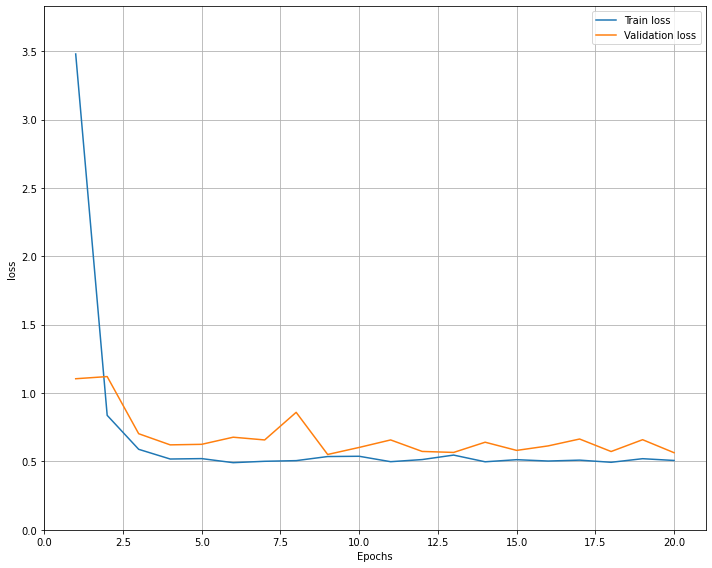

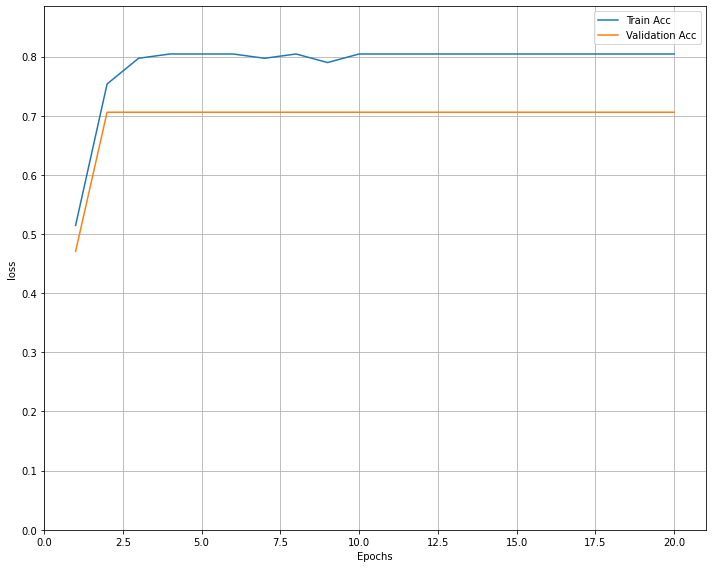

In [ ]:
cnn_trainer.train()

In [ ]:
cnn_trainer.test(20)

----------Start testing CNN model----------
Test Accuracy = 0.7058823529411765


In [ ]:
seg_loss =nn.BCELoss().cuda()
encoder_s,encoder_t,decoder=trainer.get_ckpt(epoch=1, time=1)
val_loss=trainer.model_eval(encoder_s,decoder,seg_loss)
# trainer.model_test(epoch=1)

----------Start validating model----------


In [ ]:
epoch=1
print("[{0:d}:validation] --- loss_seg:{1:.10f}".format(epoch + 1,val_loss))

[2:validation] --- loss_seg:0.6863833904


In [ ]:
trainer.model_test(epoch=1)

In [ ]:

image_list = os.listdir('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2')
image_list

['binary_image_1',
 'binary_image_0',
 'greyscale_image_0',
 'binary_image_2',
 'greyscale_image_1',
 'greyscale_image_2',
 'binary_image_5']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Test

In [ ]:
# image_path = '/content/drive/My Drive/FYP/ECGpdf2data/data/train/cropped_png/cropped'
image_path = '/content/drive/My Drive/FYP/ECGpdf2data/data/train/digitized_paper'
image_list = os.listdir(image_path)
image_list = [x for x in image_list if '.DS_Store' not in x]
image_list = [x for x in image_list if '.ipynb_checkpoints' not in x]

FileNotFoundError: ignored

In [ ]:
len(image_list),type(image_list[0])

In [ ]:
image_list

In [ ]:
image_list= [x[0:-4] for x in image_list]
image_list, type(image_list[0])

In [ ]:
image_path_3 = '/content/drive/My Drive/FYP/ECGpdf2data/dataset/12_lead_ECG/test'
image_list_3 = os.listdir(image_path_3)
image_list_3  = [x for x in image_list_3  if '.DS_Store' not in x]
image_list_3  = [x for x in image_list_3 if '.ipynb_checkpoints' not in x]

In [ ]:
len(image_list_3)

In [ ]:
import io
!pip install -q xlrd

In [ ]:
df=pd.read_excel('/content/drive/My Drive/FYP/ECGpdf2data/dataset/12_lead_ECG/12_lead_ECG_DL_train.xlsx')

print(df)

In [ ]:
data=df['ID'].values

data_=data.tolist()

In [ ]:
type(data_[0])

In [ ]:
# from contextlib import ExitStack
results=[]
for data in data_:
  
  # if(df['ID'] != int(image[0:-4])):
  #   print(image[0:-4])
  exist=0
  for i in range(0,len(image_list)):
    if str(data) == image_list[i]: exist=1
  if(exist==0):
    results.append(data)
# results  = [x for x in data_ if x not in image_list]
  # result = df[df['ID'] != int(image[0:-4])]
  # print(result)
  # label = result['Diagnosis'].values[0]  # 应该加在default loader里面
  # mask_target.append(label)

In [ ]:
len(results)

In [ ]:
results

#Jpg to png

In [ ]:
from PIL import Image

imagr_folder=('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/digitized_paper')



In [ ]:
image_list = os.listdir(imagr_folder)
image_list = [x for x in image_list if '.DS_Store' not in x]
image_list = [x for x in image_list if '.ipynb_checkpoints' not in x]

In [ ]:
for image in image_list:
  im1 = Image. open(r'/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/digitized_paper/'+image)
  im1. save(r'/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/digitized_paper2/'+image[0:-4]+'.png')
  

In [ ]:
import os
os.mkdir('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/binary_image_5')

FileExistsError: ignored

In [ ]:
from os import path

if path.exists('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/binary_image_5') == False:
  os.mkdir('/content/drive/My Drive/FYP_Yixin_Cai/GAA_data/test/output2/binary_image_5')